In [1]:
#- - - - - - - - - - - - - - -  Import required modules/packages/dependencies- - - - - - - - - - - - - - - - - - - - - _
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import cartopy
import geopandas as gpd
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import os
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import folium
import ipywidgets
from IPython.display import HTML, display
import numpy as np

plt.ion()  # make the plotting interactive



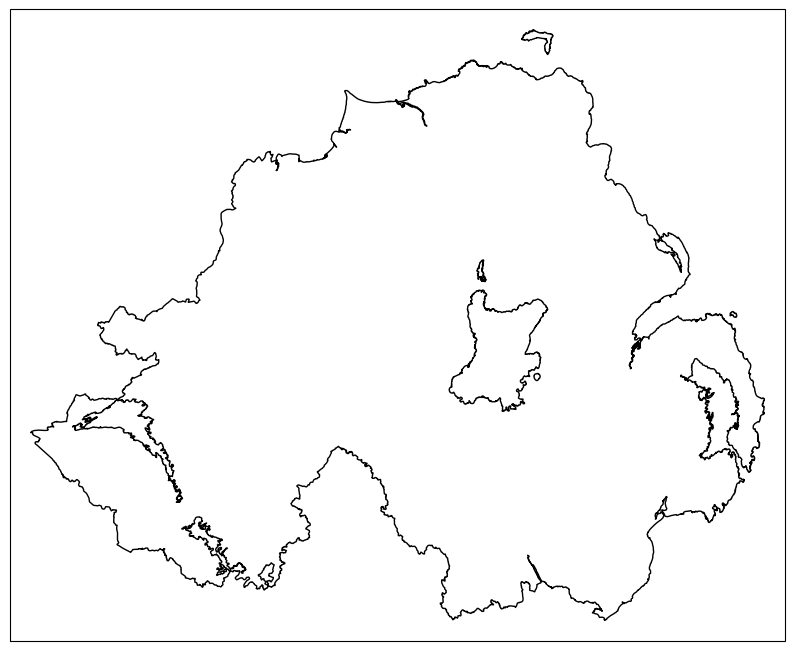

In [2]:
#- - - - - - - - - - - - - - -  Initial Map SetUp- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - -

# generate matplotlib handles to create a legend of features in output map
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

# creates a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
def scale_bar(ax, location=(0.92, 0.95)):
    x0, x1, y0, y1 = ax.get_extent()
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=7, transform=ax.projection)
    ax.plot([sbx, sbx - 5000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
    ax.plot([sbx-5000, sbx - 10000], [sby, sby], color='w', linewidth=6, transform=ax.projection)
    ax.plot([sbx-9000, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=ax.projection)

    ax.text(sbx, sby-4500, '10 km', transform=ax.projection, fontsize=6)
    ax.text(sbx-4250, sby-4500, '5', transform=ax.projection, fontsize=6)#  should be 6250 but doesn't place well
    ax.text(sbx-9750, sby-4500, '1', transform=ax.projection, fontsize=6)# should be 11250 but doesn't place well
    ax.text(sbx-12500, sby-4500, '0', transform=ax.projection, fontsize=6)
    #ax.text(sbx-24500, sby-4500, '0 km', transform=ax.projection, fontsize=6)

# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
#def scale_bar(ax, location=(0.92, 0.95)):
    #x0, x1, y0, y1 = ax.get_extent()
    #sbx = x0 + (x1 - x0) * location[0]
    #sby = y0 + (y1 - y0) * location[1]

    #ax.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=ax.projection)
    #ax.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=ax.projection)
    #ax.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=ax.projection)

    #ax.text(sbx, sby-4500, '20 km', transform=ax.projection, fontsize=8)
    #ax.text(sbx-12500, sby-4500, '10 km', transform=ax.projection, fontsize=8)
    #ax.text(sbx-24500, sby-4500, '0 km', transform=ax.projection, fontsize=8)
    
plt.ion() # make the plotting interactive

# create a crs using ccrs.UTM() that corresponds to our CRS
myCRS = ccrs.UTM(29) # create a Universal Transverse Mercator reference system to transform our data.

myFig = plt.figure(figsize=(10, 10))  # create a figure of size 10x10 (representing the page size in inches)

ax = plt.axes(projection=myCRS)  # finally, create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.


outline = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/egm722_Practicals/egm722/week2/data_files/NI_outline.shp')) # load the outline of Northern Ireland for a backdrop


# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')

xmin, ymin, xmax, ymax = outline.total_bounds
ax.add_feature(outline_feature)  # add the features we've created to the map.

# using the boundary of the shapefile features, zoom the map to our area of interest
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=myCRS)  # because total_bounds
# gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.




In [15]:
print(lakes.loc())

   OBJECTID                name  lake_code     squ_metre    area_ha  centre_x   
0         1         Lough Neagh  Lake_0024  3.812689e+08  38126.885    302265  \
1         2  Tradd Point Pond 1  Lake_0142  7.590544e+03      0.759    295105   
2         3          Ballylough  Lake_0074  1.225650e+05     12.257    336240   
3         4  Traad Point Pond 2  Lake_0143  1.319528e+04      1.320    295140   
4         5  Traad Point Pond 3  Lake_0144  2.606167e+03      0.261    295358   

   centre_y  ehro_2007  county   border_m  ...                  name_12   
0  375073.0          3  Tyrone  229598.42  ...  Lough Neagh Peripherals  \
1  387258.0          2   Derry     677.17  ...  Lough Neagh Peripherals   
2  337799.0          6    Down    1746.21  ...            Carrigs River   
3  387103.0          2   Derry    1479.62  ...  Lough Neagh Peripherals   
4  387309.0          2   Derry     219.86  ...  Lough Neagh Peripherals   

              ms_cd         town     distance  SHAPE__Len SHAP

IndexError: list index out of range

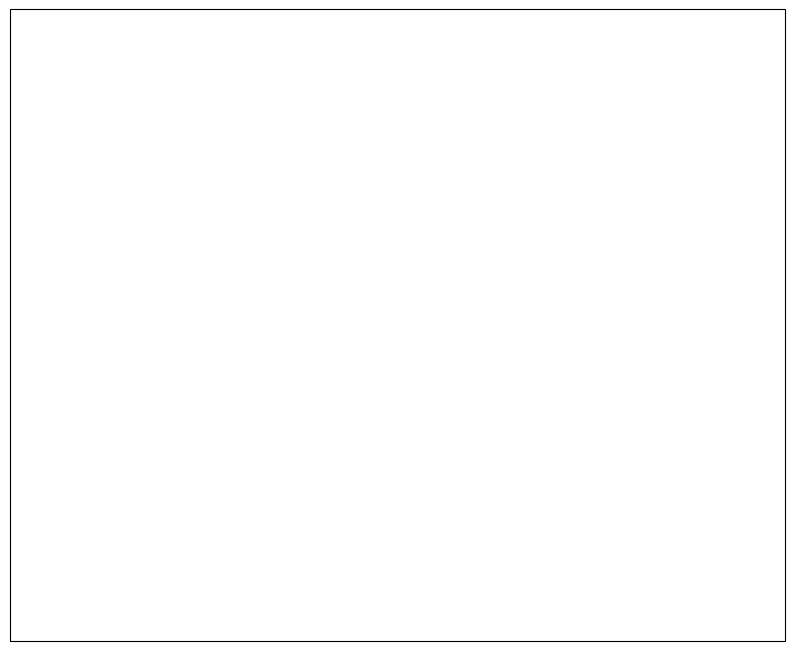

In [14]:
#- - - - - - - - - - - - - - -  Add initial data- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -- - - -

# load the necessary data here 
counties = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/egm722_Practicals/egm722/week2/data_files/Counties.shp'))
wards = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/egm722_Practicals/egm722/week3/data_files/NI_Wards.shp'))
towns = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/egm722_Practicals/egm722/week2/data_files/Towns.shp'))
water = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/egm722_Practicals/egm722/week2/data_files/Water.shp'))
rivers = gpd.read_file(os.path.abspath('c:/Carol_PG_CERT_GIS/egm722_Practicals/egm722/week2/data_files/Rivers.shp'))
farmCensusDEA = gpd.read_file('c:/Carol_PG_CERT_GIS/data/FarmCensusDistrictElectoralArea2019.shp')
lakes= gpd.read_file('c:/Carol_PG_CERT_GIS/data/Lakes_of_Northern_Ireland.shp')

#and transform to a UTM projection
#counties = counties.to_crs(epsg=2157)
#wards = wards.to_crs(epsg=2157)

# create a figure of size 10x10 (representing the page size in inches)
myFig = plt.figure(figsize=(10, 10))

myCRS = ccrs.UTM(29)  # create a Universal Transverse Mercator reference system to transform our data.
# NI is in UTM Zone 29, so we pass 29 to ccrs.UTM()

ax = plt.axes(projection=myCRS)  # finally, create an axes object in the figure, using a UTM projection,
# where we can actually plot our data.

# first, we just add the outline of Northern Ireland using cartopy's ShapelyFeature
outline_feature = ShapelyFeature(outline['geometry'], myCRS, edgecolor='k', facecolor='w')

#xmin, ymin, xmax, ymax = outline.total_bounds
#ax.add_feature(outline_feature)  # add the features we've created to the map.

# using the boundary of the shapefile features, zoom the map to our area of interest
ax.set_extent([xmin-5000, xmax+5000, ymin-5000, ymax+5000], crs=myCRS)  # because total_bounds
# gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.

# pick colors, add features to the map
county_colors = ['firebrick', 'seagreen', 'royalblue', 'coral', 'violet', 'cornsilk']

# get a list of unique counties for the lake polys
lake_names = list(lakes.county.unique())
lake_names.sort()  # sort the counties alphabetically by name

# next, add the municipal outlines to the map using the colors that we've picked.
# here, we're iterating over the unique values in the 'CountyName' field.
# we're also setting the edge color to be black, with a line width of 0.5 pt.
# Feel free to experiment with different colors and line widths.
for ii, name in enumerate(lakes):
    feat = ShapelyFeature(lakes.loc[lakes['name'] == name, 'geometry'],  # first argument is the geometry
                          myCRS,  # second argument is the CRS
                          edgecolor='k',  # outline the feature in black
                          facecolor=county_colors[ii],  # set the face color to the corresponding color from the list
                          linewidth=1,  # set the outline width to be 1 pt
                          alpha=0.25)  # set the alpha (transparency) to be 0.25 (out of 1)
    #ax.add_feature(feat)  # once we have created the feature, we have to add it to the map using ax.add_feature()



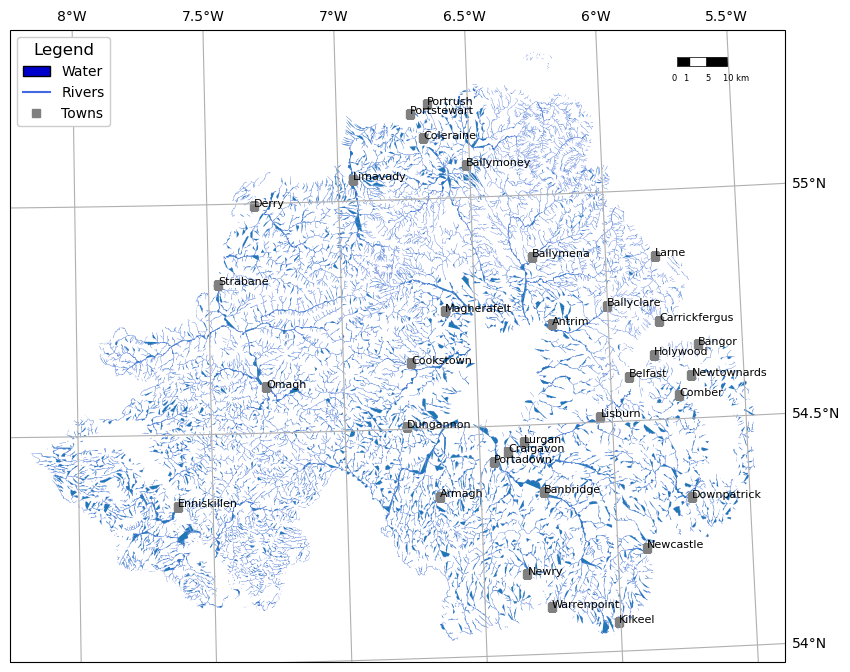

In [11]:
# here, we're setting the edge color to be the same as the face color. Feel free to change this around,
# and experiment with different line widths.
#water_feat = ShapelyFeature(water['geometry'],  # first argument is the geometry
                            #myCRS,  # second argument is the CRS
                            #edgecolor='mediumblue',  # set the edgecolor to be mediumblue
                            #facecolor='mediumblue',  # set the facecolor to be mediumblue
                            #linewidth=1)  # set the outline width to be 1 pt
#ax.add_feature(water_feat)  # add the collection of features to the map


Fcensus_feat = ShapelyFeature(farmCensusDEA['geometry'],  # first argument is the geometry
                            myCRS,  # second argument is the CRS
                            edgecolor='mediumblue',  # set the edgecolor to be mediumblue
                            facecolor='mediumblue',  # set the facecolor to be mediumblue
                            linewidth=1)  # set the outline width to be 1 pt




#lakes




river_feat = ShapelyFeature(rivers['geometry'],  # first argument is the geometry
                            myCRS,  # second argument is the CRS
                            edgecolor='royalblue',  # set the edgecolor to be royalblue
                            linewidth=0.2)  # set the linewidth to be 0.2 pt
ax.add_feature(river_feat)  # add the collection of features to the map

# ShapelyFeature creates a polygon, so for point data we can just use ax.plot()
town_handle = ax.plot(towns.geometry.x, towns.geometry.y, 's', color='0.5', ms=6, transform=myCRS)

# generate a list of handles for the county datasets
lake_handles = generate_handles(lakes.name.unique(), lake_colors, alpha=0.25)

# note: if you change the color you use to display lakes, you'll want to change it here, too
water_handle = generate_handles(['Water'], ['mediumblue'])

# note: if you change the color you use to display rivers, you'll want to change it here, too
river_handle = [mlines.Line2D([], [], color='royalblue')]  # have to make this a list

# update county_names to take it out of uppercase text
#nice_names = [name.title() for name in county_names]

# ax.legend() takes a list of handles and a list of labels corresponding to the objects you want to add to the legend
#for haneles- might want to add in county_handles in future: " = county_handles + water_handle + river_handle + town_handle "
handles = water_handle + river_handle + town_handle
#for labels- might want to add in nice names in fure -use "nice_names + ['Water', 'Rivers', 'Towns'] "
labels = ['Water', 'Rivers', 'Towns']

leg = ax.legend(handles, labels, title='Legend', title_fontsize=12,
                fontsize=10, loc='upper left', frameon=True, framealpha=1)

gridlines = ax.gridlines(draw_labels=True,  # draw  labels for the grid lines
                         xlocs=[-8, -7.5, -7, -6.5, -6, -5.5],  # add longitude lines at 0.5 deg intervals
                         ylocs=[54, 54.5, 55, 55.5])  # add latitude lines at 0.5 deg intervals
gridlines.left_labels = False  # turn off the left-side labels
gridlines.bottom_labels = False  # turn off the bottom labels

# add the text labels for the towns
for ind, row in towns.iterrows():  # towns.iterrows() returns the index and row
    x, y = row.geometry.x, row.geometry.y  # get the x,y location for each town
    ax.text(x, y, row['TOWN_NAME'].title(), fontsize=8, transform=myCRS)  # use plt.text to place a label at x,y

# add the scale bar to the axis
scale_bar(ax)

# save the figure as map_ipythonTest.png, cropped to the axis (bbox_inches='tight'), and a dpi of 300
myFig.savefig('map_ipythoTest.png', bbox_inches='tight', dpi=300)

myFig



In [ ]:


#- - - - - - - - - - - - - - -  Carry out spatial analyses- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#oneKmBuffer = bike_station_locations.geometry.buffer(1)
#oneKmBuffer.head()
#print(oneKmBuffer.head())
#for index, row in bike_station_locations.iterrows():



#TODO: define and code for further analyses



# your analysis goes here...counties have been removed

join = gpd.sjoin(counties, wards, how='inner', lsuffix='left', rsuffix='right') # perform the spatial join of counties and wards
joinedData = join.groupby(['CountyName'])['Population'].sum() # assign summary data to variable to be printed
print(joinedData)
# below here, you may need to modify the script somewhat to create your map.






# to make a nice colorbar that stays in line with our map, use these lines:
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)


# plot the ward data into our axis, using
ward_plot = wards.plot(column='Population', ax=ax, vmin=1000, vmax=8000, cmap='viridis',
                       legend=True, cax=cax, legend_kwds={'label': 'Resident Population'})


county_outlines = ShapelyFeature(counties['geometry'], myCRS, edgecolor='r', facecolor='none')


ax.add_feature(county_outlines)
county_handles = [mpatches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor='r')]

ax.legend(county_handles, ['County Boundaries'], fontsize=12, loc='upper left', framealpha=1)

# save the figure
fig.savefig('sample_map22.png', dpi=300, bbox_inches='tight')

fig


#- - - - - - - - - - - - - - -  Present results from analysis- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#TODO: present results


#- - - - - - - - - - - - - - - Output the final map- - - - - - - - - - - - - - -

# add gridlines below
gridlines = ax.gridlines(draw_labels=True,
                         xlocs=[-8, -7.5, -7, -6.5, -6, -5.5],
                         ylocs=[54, 54.5, 55, 55.5],
                         linewidth = 0.5, color = 'gray', alpha = 0.5, linestyle='--')

gridlines.right_labels = False
gridlines.bottom_labels = False
gridlines.left_labels = True
gridlines.top_labels = True

In [ ]:


''''# - - - - - - - - - - - - - - -  Create the Folium map- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# this creates the map and centres the map on the mean x,y of all bike station locations
#map = folium.Map(location=[bike_station_locations.Latitude.mean(), bike_station_locations.Longitude.mean()],
                 zoom_start=14, control_scale=True)

# - - - - - - - - - - - - - - -  Add data to the map- - - - - - - - - - - - - -- - - - - - - - - - - - - - - - - - - - -
# this adds the bike station point locations to the map and uses the location field as a popup label
#for index, row in bike_station_locations.iterrows():
#    lat = row['Latitude']
#    long = row['Longitude']
#    name = row['Location']

 #   folium.Marker([lat, long], name).add_to(map)

# add data layers control
#folium.LayerControl().add_to(map)
# TODO: configure widget
#- - - - - - - - - - - - - - - Finishing Touches- - - - - - - - - - - - - - -- - - - - - - - - - - - - - - - - - - - - -
#this adds a title to the map   
#mapTitle = 'Belfast Bike Locations'
#title_html = '''
#             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
#            '''.format(mapTitle)
#
#map.get_root().html.add_child(folium.Element(title_html))

#- - - - - - - - - - - - - - - Save the Folium map- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
##this saves the map as html
#map.save("Belfast bikes.html")